In [ ]:
import json, sys, os, math
sys.path.append(os.path.abspath("backend/app"))
from Functions import functions
import pandas as pd, numpy as np
import geopandas as gpd
import xarray as xr, matplotlib.pyplot as plt
from scipy.interpolate import Rbf

In [ ]:
hyd_map_path = r'backend\Delft_Projects\demo\output\HYD\FlowFM_map.zarr'
# hyd_his_path = r'backend\Delft_Projects\demo\output\HYD\FlowFM_his.zarr'
# wq_his_path = r'backend\Delft_Projects\demo\output\WAQ\Cadmium_his.zarr'
wq_map_path = r'backend\Delft_Projects\demo\output\WAQ\Cadmium_map.zarr'
# waq_his = xr.open_zarr(wq_his_path)
waq_map = xr.open_zarr(wq_map_path)
# hyd_his = xr.open_zarr(hyd_his_path)
hyd_map = xr.open_zarr(hyd_map_path)
# # Save to zarr
# hyd_map.to_zarr(r'backend\Delft_Projects\team\output\HYD\FlowFM_map.zarr', mode='w', consolidated=False)

In [26]:
key, query, data, idx = 'waq', 'mesh2d_IM1', waq_map, -1
# key, query, data, idx = 'hyd', 'mesh2d_tem1', hyd_map, -1
is_hyd = key == 'hyd'
name = functions.variablesNames.get(query, query)
layer_reverse = functions.layerCounter(hyd_map)
with open('ids.json', 'r') as f:
    ids = json.load(f)
ids_arr = np.array(ids)
x_coords, y_coords = ids_arr[:, 2], ids_arr[:, 1]
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x_coords, y_coords), crs='epsg:4326')
# Interpolate data
x = hyd_map['mesh2d_node_x'].values
y = hyd_map['mesh2d_node_y'].values
z = hyd_map['mesh2d_node_z'].values
gdf['depth'] = functions.interpolation_Z(gdf, x, y, z)
layers_values = np.array([float(v.split(' ')[1]) for k, v in layer_reverse.items() if int(k) >= 0])
max_layer = float(max(layers_values, key=abs))
n_rows = abs(math.ceil(max_layer/10)*10) if max_layer > 0 else abs(math.floor(max_layer/10)*10)+1
arr, depth_idx = data[name].values, np.array([round(abs(d)) for d in layers_values])
index_map = {int(v): depth_idx.shape[0] - i - 1 for i, v in enumerate(depth_idx)}
cache = { "layers_values": layers_values, "n_rows": n_rows, "df": gdf.drop(columns=['geometry']),
    "depth_idx": depth_idx, "index_map": index_map, "max_layer": max_layer}

In [28]:
frame, arr_selected, df = {}, arr[idx,:,:], cache["df"]
# Create a mask
mask = cache["layers_values"][None, :] < df["depth"].values[:, None]
depth_rounded = np.round(df["depth"].values, 0)
for i in range(cache["n_rows"]):
    # Initialize column
    if -i not in frame: frame[-i] = np.full(len(df), np.nan)
    # Assign values to column using the nearest neighbor depth
    mask_depth = -i == depth_rounded
    if np.any(mask_depth):
        nearest_idx = np.argmin(np.abs(cache["depth_idx"] - i))
        temp_values = arr_selected[df.index.values, nearest_idx] if is_hyd else arr_selected[nearest_idx, df.index.values]
        frame[-i] = np.where(mask_depth, temp_values, frame[-i])
    if i in cache["index_map"]:
        mask = -i >= df["depth"].values
        index = cache["index_map"][i]
        temp_values = arr_selected[df.index.values, index] if is_hyd else arr_selected[index, df.index.values]
        frame[-i] = np.where(mask, temp_values, frame[-i])
poly = pd.concat([df[['depth']].reset_index(drop=True), pd.DataFrame(frame)], axis=1)
# Get indices of valid columns
depth_arr = np.array([float(c) for c in poly.columns if c != "depth"])
smoothed = poly.drop("depth", axis=1).to_numpy(dtype=float)
mask_valid = depth_arr[None, :] >= depth_rounded[:, None]
x_idx, y_idx = np.where(~np.isnan(smoothed) & mask_valid)
vals = smoothed[x_idx, y_idx]
# If only one point, use that value for the whole grid cell
if vals.min() == vals.max(): smoothed[:, :] = vals.min()
else:
    rbf = Rbf(x_idx, y_idx, vals, function='linear')
    grid_x, grid_y = np.indices(smoothed.shape)
    smoothed = rbf(grid_x, grid_y)
smoothed[~mask_valid] = np.nan
# Transpose
smoothed_transpose = smoothed.T
# Get maximum indice to be used as mask
max_row = np.max(np.where(mask_valid.T)[0])
smoothed_transpose = smoothed_transpose[:max_row + 2, :]

In [34]:
functions.numberFormatter(smoothed_transpose)

[[4.65e-05,
  3.33e-05,
  2.01e-05,
  8.67e-06,
  -2.44e-07,
  -6.5e-06,
  -1.05e-05,
  -1.26e-05,
  -1.35e-05,
  -1.35e-05,
  -1.29e-05,
  -1.2e-05,
  -1.09e-05,
  -9.73e-06,
  -8.57e-06,
  -7.47e-06,
  -6.46e-06,
  -5.55e-06,
  -4.76e-06,
  -4.07e-06,
  -3.48e-06,
  -2.99e-06,
  -2.57e-06,
  -2.22e-06,
  -1.92e-06,
  -1.68e-06,
  -1.47e-06,
  -1.29e-06,
  -1.14e-06,
  -1.01e-06,
  -8.96e-07,
  -7.97e-07,
  -7.08e-07,
  -6.29e-07,
  -5.58e-07,
  -4.94e-07,
  -4.35e-07,
  -3.81e-07,
  -3.31e-07,
  -2.85e-07,
  -2.42e-07,
  -2.02e-07,
  -1.65e-07,
  -1.31e-07,
  -9.85e-08,
  -6.83e-08,
  -3.99e-08,
  -1.32e-08,
  1.18e-08,
  3.54e-08,
  5.77e-08,
  7.88e-08,
  9.87e-08,
  1.18e-07,
  1.36e-07,
  1.53e-07,
  1.69e-07,
  1.84e-07,
  1.99e-07,
  2.13e-07,
  2.27e-07,
  2.4e-07,
  2.53e-07,
  2.65e-07,
  2.77e-07,
  2.89e-07,
  3e-07,
  3.11e-07,
  3.22e-07,
  3.33e-07,
  3.43e-07,
  3.54e-07,
  3.64e-07,
  3.75e-07,
  3.85e-07,
  3.95e-07,
  4.06e-07,
  4.16e-07,
  4.27e-07,
  4.38e-07,
  

In [32]:
pd.DataFrame(smoothed_transpose)

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
0,0.000046,0.000033,0.000020,8.670783e-06,-2.444194e-07,-0.000007,-0.000010,-0.000013,-0.000014,-0.000013,...,8.397130e-07,8.823985e-07,9.312849e-07,9.881240e-07,1.055359e-06,1.136377e-06,1.235749e-06,1.359232e-06,1.513181e-06,1.703030e-06
1,0.000051,0.000035,0.000018,4.847020e-06,-4.633127e-06,-0.000011,-0.000014,-0.000015,-0.000015,-0.000014,...,6.250664e-07,6.572262e-07,6.941511e-07,7.373354e-07,7.890124e-07,8.525689e-07,9.331138e-07,1.038010e-06,1.176639e-06,1.358071e-06
2,0.000058,0.000036,0.000015,-2.810690e-07,-9.516201e-06,-0.000014,-0.000016,-0.000016,-0.000016,-0.000014,...,4.316837e-07,4.539193e-07,4.793770e-07,5.091289e-07,5.448958e-07,5.895599e-07,6.481013e-07,7.291207e-07,8.462848e-07,1.016026e-06
3,0.000069,0.000036,0.000009,-6.618736e-06,-1.373862e-05,-0.000016,-0.000017,-0.000016,-0.000014,-0.000012,...,2.616281e-07,2.749992e-07,2.901416e-07,3.076201e-07,3.284027e-07,3.542843e-07,3.888752e-07,4.400242e-07,5.252651e-07,6.763814e-07
4,0.000088,0.000027,-0.000001,-1.087751e-05,-1.353971e-05,-0.000014,-0.000013,-0.000011,-0.000009,-0.000008,...,1.169653e-07,1.229002e-07,1.294828e-07,1.368562e-07,1.452780e-07,1.552789e-07,1.681081e-07,1.872650e-07,2.254686e-07,3.382774e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


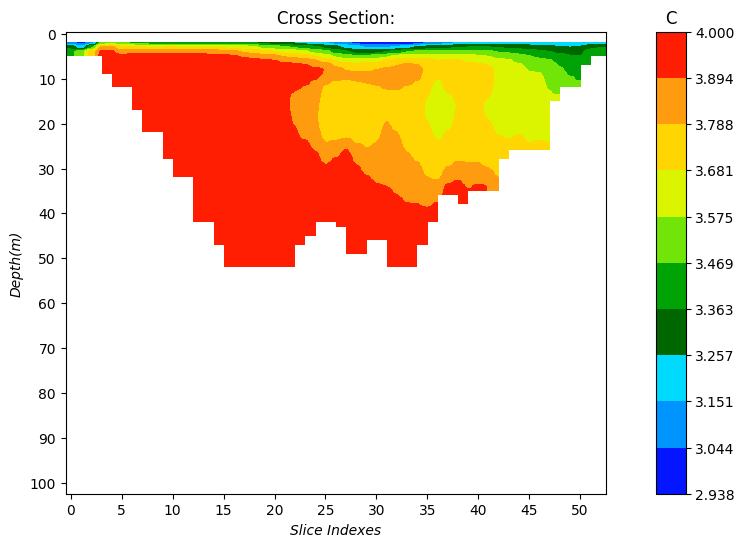

In [ ]:
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(8, 6))
temp_cmap = ["#0416FF", "#0094FF", "#00DAFF", "#006600", "#00A305", "#71E507", "#DBF400", "#FFD602",
                "#FF9B0F", "#FF1E01"]
cmap = colors.ListedColormap(temp_cmap)
# Get min and max values of the data
min_value, max_value = data.min().min(), data.max().max()
if min_value < max_value: boundaries = np.linspace(min_value, max_value, cmap.N + 1).tolist()
else: boundaries = np.linspace(0, max_value, cmap.N + 1).tolist()
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
img = ax.imshow(data, interpolation='kaiser', cmap=colors.ListedColormap(temp_cmap), norm=norm, aspect='auto')
cax = cax = make_axes_locatable(ax).append_axes("right", size=0.3, pad=0.5)
colorbar = fig.colorbar(img, cax=cax, ticks=boundaries)
colorbar.ax.set_title('C')
ax.set_title("Cross Section:")
ax.tick_params(axis='x', rotation=0, labelsize=10)
ax.tick_params(axis='y', rotation=0, labelsize=10)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_ylabel("Depth(m)", fontsize=10, style='italic')
ax.set_xlabel("Slice Indexes", fontsize=10, style='italic')
ax.set_xticks(np.arange(0, len(data.columns) + 1, 5))
ax.set_yticks(np.arange(0, len(data), 10))
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_cross_section(df_grid, variable="Variable", unit="", color_list=None):
    """
    Vẽ cross-section heatmap từ DataFrame df_grid
    
    Args:
        df_grid (pd.DataFrame): DataFrame với index = depth, columns = slice index
        variable (str): Tên biến để hiển thị
        unit (str): Đơn vị của biến
        color_list (list): Danh sách màu cho colormap
    """
    
    if color_list is None:
        # Colormap mặc định (10 màu gradient)
        color_list = ["#0416FF", "#0094FF", "#00DAFF", "#006600", "#00A305", 
                      "#71E507", "#DBF400", "#FFD602", "#FF9B0F", "#FF1E01"]
    
    # Chuyển sang numpy array
    data = df_grid.values.astype(float)
    
    # Xác định min/max
    min_value, max_value = np.nanmin(data), np.nanmax(data)
    
    # Colormap
    cmap = colors.ListedColormap(color_list)
    if min_value < max_value:
        boundaries = np.linspace(min_value, max_value, cmap.N + 1)
    else:
        boundaries = np.linspace(0, max_value, cmap.N + 1)
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    
    # Vẽ
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(data, interpolation='kaiser', cmap=cmap, norm=norm, aspect='auto')
    
    # Grid và labels
    ax.grid(False)
    ax.set_title(f"Cross Section: {variable}")
    ax.set_xlabel("Slice Indexes", fontsize=10, style='italic')
    ax.set_ylabel("Depth (m)", fontsize=10, style='italic')
    
    # Ticks
    ax.set_xticks(np.arange(0, df_grid.shape[1], max(1, df_grid.shape[1]//10)))
    ax.set_yticks(np.arange(0, df_grid.shape[0], max(1, df_grid.shape[0]//10)))
    
    # Colorbar
    cbar = fig.colorbar(img, ax=ax, ticks=boundaries)
    cbar.ax.set_title(unit)
    
    plt.show()

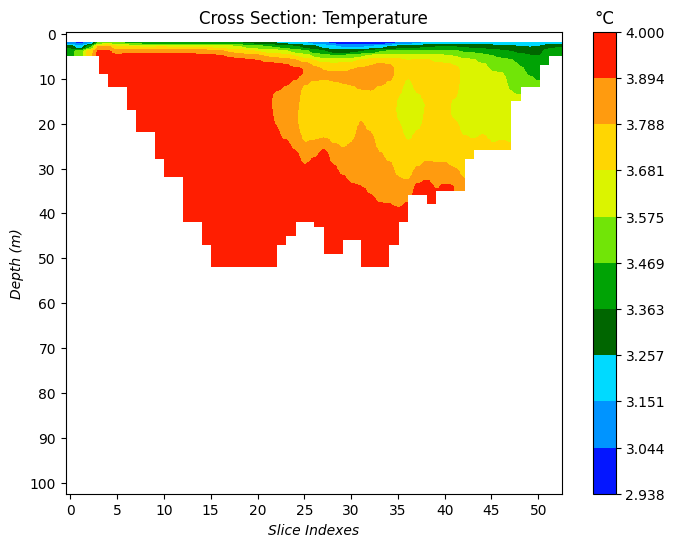

In [27]:
plot_cross_section(data, variable="Temperature", unit="°C")

In [71]:
# Get units
for key, var in waq_map.variables.items():
    # units = var.attrs.get('long_name', 'units')
    # print(f"{var}: {units}")
    print(key, var)

mesh2d <xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes: (12/18)
    cf_role:                   mesh_topology
    edge_coordinates:          mesh2d_edge_x mesh2d_edge_y
    edge_dimension:            mesh2d_nEdges
    edge_face_connectivity:    mesh2d_edge_faces
    edge_node_connectivity:    mesh2d_edge_nodes
    face_coordinates:          mesh2d_face_x mesh2d_face_y
    ...                        ...
    long_name:                 Topology data of 2D mesh
    max_face_nodes_dimension:  mesh2d_nMax_face_nodes
    node_coordinates:          mesh2d_node_x mesh2d_node_y
    node_dimension:            mesh2d_nNodes
    topology_dimension:        2
    vertical_dimensions:       mesh2d_nLayers: mesh2d_nInterfaces (padding: n...
mesh2d_2d_Cd <xarray.Variable (nTimesDlwq: 62, mesh2d_nFaces: 4935)> Size: 1MB
dask.array<open_dataset-mesh2d_2d_Cd, shape=(62, 4935), dtype=float32, chunksize=(1, 4935), chunktype=numpy.ndarray>
Attributes:
    cell_measures:  volume: mesh2d_vol

In [15]:
list(waq_map.variables.keys())

['mesh2d',
 'mesh2d_node_x',
 'mesh2d_node_y',
 'mesh2d_edge_x',
 'mesh2d_edge_y',
 'mesh2d_face_x_bnd',
 'mesh2d_face_y_bnd',
 'mesh2d_edge_nodes',
 'mesh2d_edge_faces',
 'mesh2d_face_nodes',
 'mesh2d_layer_dlwq',
 'nTimesDlwqBnd',
 'mesh2d_NH4',
 'mesh2d_2d_NH4',
 'mesh2d_CBOD5',
 'mesh2d_2d_CBOD5',
 'mesh2d_OXY',
 'mesh2d_2d_OXY',
 'mesh2d_SOD',
 'mesh2d_2d_SOD',
 'mesh2d_DO',
 'mesh2d_2d_DO',
 'mesh2d_volume',
 'mesh2d_2d_volume',
 'mesh2d_face_x',
 'mesh2d_face_y',
 'nTimesDlwq']

## Preprocess data

In [4]:
velocity_layers = functions.velocityChecker(data_map)
# Write velocity layer file
with open(f'{temp_folder}/velocity_layers.json', 'w') as f:
    json.dump(velocity_layers, f)

In [ ]:
# Get summary of the project
data = functions.getSummary(dia_file, data_his, wq_map)

In [3]:
# Generate config file
configuration, NCfiles = {}, [data_his, data_map, wq_his, wq_map]
for file in NCfiles:
    configuration.update(functions.getVariablesNames(file))
# Write config file
with open(f'{temp_folder}/configuration.json', 'w') as f:
    json.dump(configuration, f)

Checking General Hydrological File ...
Checking General Map File ...
Checking Water Quality History File ...
Checking Water Quality Map File ...


## Process his data

### Time-series data

In [ ]:
# # =============================== POINTS ===============================
# # Location of stations
# stations = functions.stationCreator(data_his)
# stations.to_file(f'{geojson_folder}/stations.geojson', driver='GeoJSON')

# columns = [name.decode('utf-8').strip() for name in data_his['station_name'].values]
# values = ['waterlevel', 'waterdepth', 'total_heat_flux', 'wind_speed', 'air_temperature', 'relative_humidity',
#           'evaporative_heat_flux', 'free_convection_evaporative_heat_flux', 'sensible_heat_flux',
#           'free_convection_sensible_heat_flux', 'long_wave_back_radiation', 'precipitation_rate', 'solar_influx', 'cloudiness']
# for i in values:
#     df = functions.timeseriesCreator(data_his, i, columns)
#     df.to_json(f'{data_folder}/{i}.json', orient='split', date_format='iso', indent=3)

# # =============================== CROSS SECTION ===============================
# section_names = [name.decode('utf-8').strip() for name in data_his['cross_section_name'].values]






# # =============================== WATER BALANCE ===============================
# column_name = ['Water Balance']
# values = ['water_balance_total_volume', 'water_balance_storage', 'water_balance_boundaries_in',
#           'water_balance_boundaries_out', 'water_balance_boundaries_total', 'water_balance_precipitation_total',
#           'water_balance_evaporation', 'water_balance_source_sink', 'water_balance_groundwater_in',
#           'water_balance_groundwater_out', 'water_balance_groundwater_total', 'water_balance_precipitation_on_ground',
#           'water_balance_volume_error']
# for i in values:
#     df = functions.timeseriesCreator(data_his, i, column_name)
#     df.to_json(f'{data_folder}/{i}.json', orient='split', date_format='iso', indent=3)


# # Bed shear stress at stations
# df_x = delft3d.tausx.rename(columns={key: f'{key}_x' for key in delft3d.tausx.columns})
# df_y = delft3d.tausy.rename(columns={key: f'{key}_y' for key in delft3d.tausy.columns})
# df_bss = pd.concat([df_x, df_y], axis=1)
# df_bss.reset_index().to_json(f'{data_folder}/bed_shear_stress_timeseries.json', orient='split', date_format='iso', indent=3)

## Process map data

In [6]:
# # Create unstructured grid
# grid = functions.unstructuredGridCreator(data_map)

### Prepare static map

In [7]:
# # Depth at every mesh (for unstructured grid) that is interpolated from depth at nodes
# temp = grid.copy()
# temp['value'] = functions.interpolation_Z(temp, data_map['mesh2d_node_x].values, data_map['mesh2d_node_y'].values, data_map['mesh2d_node_z'].values)
# temp['value'] = temp['value'].apply(lambda x: round(x, 2))
# temp.to_file(f'{geojson_folder}/depth_static.geojson', driver='GeoJSON')

### Prepare dynamic map

In [8]:
# values = ['water_surface_dynamic', 'water_depth_dynamic',
#           'temperature_multilayers', 'salinity_multilayers', 'contaminant_multilayers']
# for i in values:
#     data = functions.assignValuesToMeshes(grid, data_map, i)
#     data.to_file(f'{geojson_folder}/{i}.geojson', driver='GeoJSON')

## OLD VERSION

### 2. Prepare template data for the option *'Cross-sections'* on menu

In [5]:
# # Location of cross-sections
# delft3d.cross_section.to_file(f'{geojson_folder}/crosssections.geojson', driver='GeoJSON')
# # Discharge at cross-sections
# delft3d.cross_section_discharges.reset_index().to_json(f'{timeseries_folder}/crossdischarge_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cumulative discharge at cross-sections
# delft3d.cross_section_cumulative_discharge.reset_index().to_json(f'{timeseries_folder}/crosscumulative_discharge_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section area
# delft3d.cross_section_area.reset_index().to_json(f'{timeseries_folder}/crossarea_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section velocity
# delft3d.cross_section_velocity.reset_index().to_json(f'{timeseries_folder}/crossvelocity_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section salinity
# delft3d.cross_section_salinity.reset_index().to_json(f'{timeseries_folder}/crosssalinity_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section cumulative salinity
# delft3d.cross_section_cumulative_salinity.reset_index().to_json(f'{timeseries_folder}/crosscumulative_salinity_timeseries.json', orient='records', date_format='iso', indent=3)
# Cross-section temperature
# delft3d.cross_section_temperature.reset_index().to_json(f'{timeseries_folder}/crosstemperature_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section cumulative temperature
# delft3d.cross_section_cumulative_temperature.reset_index().to_json(f'{timeseries_folder}/crosscumulative_temperature_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section contaminant
# delft3d.cross_section_contaminant.reset_index().to_json(f'{timeseries_folder}/crosscontaminant_timeseries.json', orient='records', date_format='iso', indent=3)
# # Cross-section cumulative contaminant
# delft3d.cross_section_cumulative_contaminant.reset_index().to_json(f'{timeseries_folder}/crosscumulative_contaminant_timeseries.json', orient='records', date_format='iso', indent=3)

### 3. Prepare template data for the option *'Water Balance'* on menu

In [ ]:
# column_name = 'Water Balance'
# data = delft3d.waterbalance_volumeerror.rename(columns={0: f'{column_name}'})
# data.reset_index().to_json(f'{temp_folder}/data/waterbalance_volumeerror.json', orient='split', date_format='iso', indent=3)

In [ ]:
# column_name = 'Water Balance'
# # Water balance total volume
# delft3d.waterbalance_totalvolume.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_totalvolume_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance storage
# delft3d.waterbalance_storage.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_storage_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance boundary inflow
# delft3d.waterbalance_boundariesin.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_boundariesin_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance boundary outflow
# delft3d.waterbalance_boundariesout.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_boundariesout_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance boundary total
# delft3d.waterbalance_boundariestotal.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_boundaries_total_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance precipitation
# delft3d.waterbalance_precipitation.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_precipitation_total_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance evaporation
# delft3d.waterbalance_evaporation.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_evaporation_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance source sink
# delft3d.waterbalance_sourcesink.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_sourcesink_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance groundwater in
# delft3d.waterbalance_groundwaterin.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_groundwaterin_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance groundwater out
# delft3d.waterbalance_groundwaterout.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_groundwaterout_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance groundwater total
# delft3d.waterbalance_groundwatertotal.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_groundwatertotal_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance precipitation on ground
# delft3d.waterbalance_precipitationonground.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_precipitationonground_timeseries.json', orient='records', date_format='iso', indent=3)
# # Water balance total volume error
# delft3d.waterbalance_volumeerror.rename(columns={0: f'{column_name}'}).reset_index().to_json(f'{timeseries_folder}/waterbalance_volumeerror_timeseries.json', orient='records', date_format='iso', indent=3)

### 4. Prepare data for the option *'2D-dynamic Maps'*
##### (Generate dynamic map for specific components during simulation period)

In [ ]:
# # Dynamic 2D
# # File _his.nc
# delft3d.depth_averaged_x_velocity, delft3d.depth_averaged_y_velocity
# # File _map.nc
# delft3d.mesh2d_ucxa, delft3d.mesh2d_ucya

In [ ]:
# # 2D-dynamic Maps

# # Water level at every mesh during the simulation
# waterlevel_path = 'waterlevel_dynamic_2D.html'
# waterlevel_mesh = functions.assign_values_to_meshes(delft3d.unstructured_grid, delft3d.map_timestamps, delft3d.mesh2d_s1)
# functions.prepare_dynamic_map_2D(waterlevel_mesh, min_max_each_time_step=False, label='Water Level (m)',
#                              output_path=f'{maps_folder}/{waterlevel_path}')
# # Water depth at every mesh during the simulation
# waterdepth_path = 'waterdepth_dynamic_2D.html'
# waterdepth_mesh = functions.assign_values_to_meshes(delft3d.unstructured_grid, delft3d.map_timestamps, delft3d.mesh2d_waterdepth)
# functions.prepare_dynamic_map_2D(waterdepth_mesh, min_max_each_time_step=False, label='Water Depth (m)', 
#                             output_path=f'{maps_folder}/{waterdepth_path}')
# # Temperature at every mesh during the simulation at top layer
# temperature_2D_path = 'temperature_toplayer_dynamic_2D.html'
# temperature_mesh = functions.assign_values_to_meshes(delft3d.unstructured_grid, delft3d.map_timestamps, delft3d.mesh2d_tem1[:, :, -1])
# functions.prepare_dynamic_map_2D(temperature_mesh, min_max_each_time_step=False, label='Temperature (°C)',
#                               output_path=f'{maps_folder}/{temperature_2D_path}')








### 5. Prepare data for the option *'3D-dynamic Maps'* on menu

In [8]:
# 3D-dynamic Maps
layers_3D = [round(x, 3) for x in delft3d.mesh2d_layer_z]

# # 3D-dynamic Maps
# result = pd.DataFrame()
# # Temperature at every mesh during the simulation
# temperature_3D_path = 'demo.html' #'temperature_toplayer_dynamic_3D.html'
# for n in range(len(layers_3D[0:2])):
#     temp_mesh = functions.assign_values_to_meshes(delft3d.unstructured_grid, delft3d.map_timestamps, delft3d.mesh2d_tem1[:, :, -(n+1)])
#     temp_mesh['layer'] = layers_3D[-(n+1)]
#     result = pd.concat([result, temp_mesh], axis=0)
# functions.prepare_dynamic_map(result, min_max_each_time_step=True, label='Temperature (°C)',
#                               output_path=f'{maps_folder}/{temperature_3D_path}')


# # Salinity at every mesh during the simulation
# salinity_path = 'salinity_dynamic_3D.html'
# salinity_mesh = pd.DataFrame()
# for i in range(len(layers_3D)):
#     temp = functions.assign_values_to_meshes(delft3d.unstructured_grid, delft3d.map_timestamps, delft3d.mesh2d_sa1[:, :, i])
#     temp['layer'] = layers_3D[i]
#     salinity_mesh = pd.concat([salinity_mesh, temp], axis=0)
# functions.prepare_dynamic_map(salinity_mesh, label='Salinity (psu)', output_path=f'{maps_folder}/{salinity_path}')

